In [3]:
import sys
sys.path.append("/home/ly/workspace/mmsa")
seed = 10086
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.multiprocessing import set_start_method, get_context

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
from models.bigru_vgg import *
from utils.train import *
from typing import *
from collections import Counter

from utils.load_yelp import *
from utils.dataset import *
from utils.train import *

In [4]:
config["embedding_dim"] = 100
config["freeze_embedding"] = True
config["text_hidden_size"] = 100
config["use_img"] = False
config

{'use_cuda': True,
 'task': 'CLS',
 'embedding_dim': 100,
 'embedding': None,
 'freeze_embedding': True,
 'text_hidden_size': 100,
 'text_layers': 1,
 'bias_init': 1.0,
 'use_img': False,
 'img_input_size': 4096,
 'img_output_size': 100,
 'img_num': 3,
 'output_size': 5,
 'dropout': 0.5}

In [5]:
train_set, valid_set, test_set = load_glove_vgg_data(split811data, config)
Counter(train_set.y), Counter(valid_set.y), Counter(test_set.y)

(Counter({1: 7102, 0: 7111, 2: 7076, 4: 7090, 3: 7066}),
 Counter({1: 887, 3: 894, 2: 908, 0: 879, 4: 862}),
 Counter({2: 877, 3: 901, 4: 909, 0: 871, 1: 872}))

In [6]:
batch_size = 128
workers = 2
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, collate_fn, train_set, valid_set, test_set)
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
model, get_parameter_number(model), loss

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


(Model(
   (word_embedding): Embedding(42834, 100)
   (gru): DynamicRNN(
     (RNN): GRU(100, 100, batch_first=True, dropout=0.5, bidirectional=True)
   )
   (output_layer): OutputLayer(
     (fc): Linear(in_features=200, out_features=5, bias=True)
     (dropout): Dropout(p=0.5, inplace=True)
   )
 ),
 {'Total': 4405605, 'Trainable': 122205},
 CrossEntropyLoss())

In [7]:
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

((0.19187358916478556, 0.15258351022869263),
 Counter({0: 1534, 4: 501, 3: 408, 2: 1951, 1: 36}))

In [8]:
%%time
_interval = 5
lr = 1e-3
epoches = 50
stoping_step = 10
optimizer = get_regal_optimizer(model, optim.AdamW, lr)

viz = get_Visdom()
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)
text_writer = VisdomTextWriter(viz, "Training")

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

res, model = train_visdom_v2(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer, text_writer,
                         _interval=_interval, early_stop=stoping_step)

Setting up a new session...
No 1 epoch: 277it [00:22, 12.21it/s]
No 2 epoch: 277it [00:22, 12.15it/s]
No 3 epoch: 277it [00:22, 12.09it/s]
No 4 epoch: 277it [00:22, 12.11it/s]
No 5 epoch: 277it [00:23, 11.94it/s]
No 6 epoch: 277it [00:23, 11.93it/s]
No 7 epoch: 277it [00:23, 11.98it/s]
No 8 epoch: 277it [00:22, 12.09it/s]
No 9 epoch: 277it [00:23, 11.76it/s]
No 10 epoch: 277it [00:22, 12.11it/s]
No 11 epoch: 277it [00:23, 11.97it/s]
No 12 epoch: 277it [00:23, 11.87it/s]
No 13 epoch: 277it [00:23, 11.73it/s]
No 14 epoch: 277it [00:23, 11.89it/s]
No 15 epoch: 277it [00:23, 11.95it/s]
No 16 epoch: 277it [00:23, 11.89it/s]
No 17 epoch: 277it [00:23, 11.82it/s]
No 18 epoch: 277it [00:23, 11.77it/s]
No 19 epoch: 277it [00:23, 11.87it/s]
No 20 epoch: 277it [00:22, 12.43it/s]
No 21 epoch: 277it [00:23, 11.98it/s]
No 22 epoch: 277it [00:23, 11.89it/s]
No 23 epoch: 277it [00:23, 11.83it/s]


CPU times: user 8min 12s, sys: 28 s, total: 8min 40s
Wall time: 10min 11s


In [9]:
res

{'min_valid_loss': 0.9503033364868595,
 'min_valid_loss_epoch': 13,
 'min_loss_train_acc': 0.47355057130765976,
 'min_valid_loss_train_loss': 1.1342227128988462,
 'min_loss_valid_acc': 0.5918735891647856,
 'last_valid_acc': 0.5553047404063205,
 'last_train_acc': 0.5669346875440824,
 'last_epoch': 23,
 'last_train_loss': 0.9101336271995919,
 'last_valid_loss': 1.1014712896626906}

In [10]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.5794582392776524, 0.5812871571095416), 0.9639991723656923)

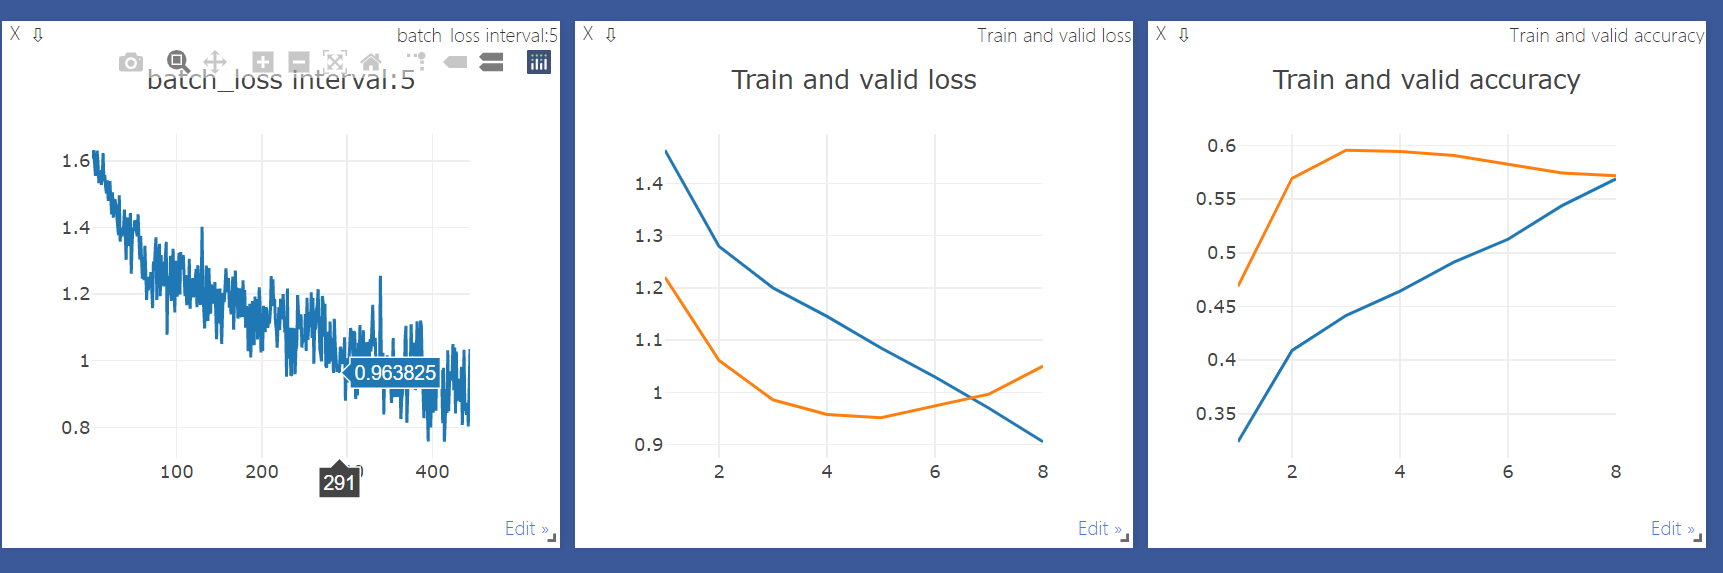

In [11]:
# 加上图片信息
config["use_img"] = True
config

{'use_cuda': True,
 'task': 'CLS',
 'embedding_dim': 100,
 'embedding': Embedding(42834, 100),
 'freeze_embedding': True,
 'text_hidden_size': 100,
 'text_layers': 1,
 'bias_init': 1.0,
 'use_img': True,
 'img_input_size': 4096,
 'img_output_size': 100,
 'img_num': 3,
 'output_size': 5,
 'dropout': 0.5,
 'vocab_size': 42822}

In [12]:
train_set, valid_set, test_set = load_glove_vgg_data(split811data, config)
Counter(train_set.y), Counter(valid_set.y), Counter(test_set.y)

(Counter({1: 7102, 0: 7111, 2: 7076, 4: 7090, 3: 7066}),
 Counter({1: 887, 3: 894, 2: 908, 0: 879, 4: 862}),
 Counter({2: 877, 3: 901, 4: 909, 0: 871, 1: 872}))

In [13]:
batch_size = 128
workers = 2
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, collate_fn, train_set, valid_set, test_set)
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
model, get_parameter_number(model), loss

(Model(
   (word_embedding): Embedding(42834, 100)
   (gru): DynamicRNN(
     (RNN): GRU(100, 100, batch_first=True, dropout=0.5, bidirectional=True)
   )
   (img_encoder): SimpleImageEncoder(
     (linear): Linear(in_features=4096, out_features=100, bias=True)
     (dropout): Dropout(p=0.5, inplace=True)
     (relu): ReLU(inplace=True)
     (pooling): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
   )
   (output_layer): OutputLayer(
     (fc): Linear(in_features=300, out_features=5, bias=True)
     (dropout): Dropout(p=0.5, inplace=True)
   )
 ),
 {'Total': 4815805, 'Trainable': 532405},
 CrossEntropyLoss())

In [14]:
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

((0.20135440180586908, 0.17567267171940398),
 Counter({3: 1796, 0: 1262, 2: 782, 1: 533, 4: 57}))

In [15]:
%%time
_interval = 5
lr = 1e-3
epoches = 50
stoping_step = 10
optimizer = get_regal_optimizer(model, optim.AdamW, lr)

viz = get_Visdom()
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)
text_writer = VisdomTextWriter(viz, "Training")

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

res, model = train_visdom_v2(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer, text_writer,
                         _interval=_interval, early_stop=stoping_step)

Setting up a new session...
No 1 epoch: 277it [00:21, 12.72it/s]
No 2 epoch: 277it [00:22, 12.51it/s]
No 3 epoch: 277it [00:21, 12.64it/s]
No 4 epoch: 277it [00:21, 12.75it/s]
No 5 epoch: 277it [00:22, 12.58it/s]
No 6 epoch: 277it [00:22, 12.43it/s]
No 7 epoch: 277it [00:22, 12.50it/s]
No 8 epoch: 277it [00:22, 12.59it/s]
No 9 epoch: 277it [00:22, 12.41it/s]
No 10 epoch: 277it [00:22, 12.59it/s]
No 11 epoch: 277it [00:22, 12.29it/s]
No 12 epoch: 277it [00:22, 12.41it/s]
No 13 epoch: 277it [00:22, 12.27it/s]
No 14 epoch: 277it [00:22, 12.34it/s]
No 15 epoch: 277it [00:22, 12.25it/s]
No 16 epoch: 277it [00:22, 12.20it/s]
No 17 epoch: 277it [00:22, 12.14it/s]
No 18 epoch: 277it [00:22, 12.11it/s]
No 19 epoch: 277it [00:23, 12.04it/s]
No 20 epoch: 277it [00:23, 11.99it/s]
No 21 epoch: 277it [00:22, 12.09it/s]
No 22 epoch: 277it [00:22, 12.06it/s]
No 23 epoch: 277it [00:22, 12.10it/s]
No 24 epoch: 277it [00:22, 12.12it/s]


CPU times: user 8min 36s, sys: 31.4 s, total: 9min 7s
Wall time: 10min 21s


In [16]:
res

{'min_valid_loss': 0.9521731312603229,
 'min_valid_loss_epoch': 14,
 'min_loss_train_acc': 0.4744533784736916,
 'min_valid_loss_train_loss': 1.1244015662218456,
 'min_loss_valid_acc': 0.5866817155756208,
 'last_valid_acc': 0.5656884875846501,
 'last_train_acc': 0.5593454648046269,
 'last_epoch': 24,
 'last_train_loss': 0.9294653388404227,
 'last_valid_loss': 1.058696473694278}

In [17]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.5812641083521445, 0.5769561452310351), 0.9541447384093739)